# MMPose预训练模型预测-Python API

## 进入 mmpose 主目录

In [1]:
import os
os.chdir('mmpose')

In [2]:
!pwd

/e/openmmlab/MMPose_DMS/mmpose


## 导入工具包

In [54]:
import cv2
import time
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [55]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [23]:
img_path = 'data/test_face/13008107_0.jpg'

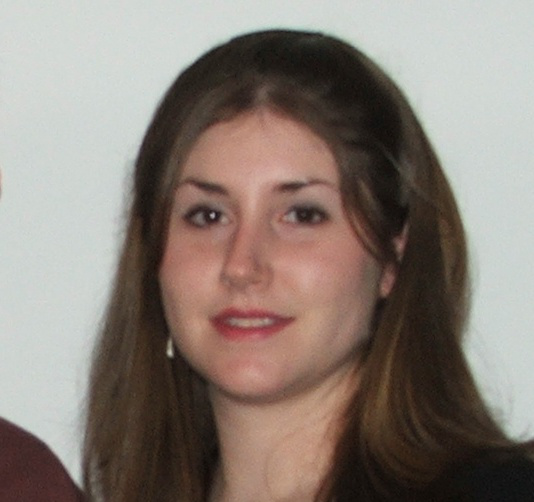

In [24]:
Image.open(img_path)

## 摄像头拍摄单帧画面

In [56]:
# 获取摄像头，0为电脑默认摄像头，1为外接摄像头
cap = cv2.VideoCapture(0)

# 拍照
time.sleep(1) # 运行本代码后等几秒拍照
# 从摄像头捕获一帧画面
success, frame = cap.read()

cap.release() # 关闭摄像头
cv2.destroyAllWindows() # 关闭图像窗口

In [58]:
Image.open(frame)

AttributeError: 'numpy.ndarray' object has no attribute 'read'

## 构建目标检测模型（任选一个运行）

In [26]:
# Faster R CNN
detector = init_detector(
    'demo/mmdetection_cfg/yolox-s_8xb8-300e_coco-face.py',
    'checkpoint/yolo-x_8xb8-300e_coco-face_13274d7c.pth',
    device=device
)

Loads checkpoint by local backend from path: checkpoint/yolo-x_8xb8-300e_coco-face_13274d7c.pth


In [27]:
# # RTMPose-Tiny
# # https://github.com/open-mmlab/mmpose/tree/dev-1.x/projects/rtmpose
# detector = init_detector(
#     'projects/rtmpose/rtmdet/person/rtmdet_m_640-8xb32_coco-person.py',
#     'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth',
#     device=device
# )

## 构建人体姿态估计模型

In [28]:
pose_estimator = init_pose_estimator(
    'configs/face_2d_keypoint/rtmpose/lapa/rtmpose-m_8xb64-120e_lapa-256x256.py',
    'checkpoint/rtmpose-m_simcc-lapa_pt-aic-coco_120e-256x256-762b1ae2_20230422.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by local backend from path: checkpoint/rtmpose-m_simcc-lapa_pt-aic-coco_120e-256x256-762b1ae2_20230422.pth


## 预测-目标检测

In [29]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

In [30]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

In [31]:
detect_result.keys()

['pred_instances', 'ignored_instances', 'gt_instances']

In [32]:
# 预测类别
detect_result.pred_instances.labels

tensor([0], device='cuda:0')

In [33]:
# 置信度
detect_result.pred_instances.scores

tensor([0.9383], device='cuda:0')

In [34]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [35]:
# 置信度阈值
CONF_THRES = 0.5

In [36]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

In [37]:
bboxes

array([[157.65343, 176.15114, 378.41754, 400.7971 ]], dtype=float32)

## 预测-关键点

In [38]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

In [39]:
len(pose_results)

1

In [40]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [41]:
data_samples.keys()

['pred_instances', '_pred_heatmaps', 'pred_fields', 'gt_instances']

## 预测结果-关键点坐标

In [42]:
# 每个人 17个关键点 坐标
data_samples.pred_instances.keypoints.shape

(1, 106, 2)

In [43]:
# 索引为 0 的人，每个关键点的坐标
data_samples.pred_instances.keypoints[0,:,:]

array([[166.02341628, 207.30322218],
       [164.37806022, 221.56297469],
       [162.73270416, 235.27427518],
       [161.63580012, 248.98557568],
       [161.63580012, 262.69687617],
       [161.63580012, 276.95662868],
       [163.28115618, 290.66792917],
       [164.92651224, 305.4761337 ],
       [167.66877234, 319.1874342 ],
       [172.0563885 , 332.89873469],
       [178.08936071, 344.96467912],
       [186.31614101, 357.03062356],
       [195.63982534, 367.45121193],
       [205.5119617 , 377.8718003 ],
       [217.57790613, 387.19548464],
       [230.7407546 , 393.77690887],
       [247.1943152 , 397.06762099],
       [265.84168386, 396.51916897],
       [283.39214849, 392.68000484],
       [299.84570909, 386.64703262],
       [315.75081766, 378.42025232],
       [330.55902219, 370.19347203],
       [343.72187066, 359.77288365],
       [355.23936307, 348.25539124],
       [364.56304741, 335.09254277],
       [371.14447165, 320.28433824],
       [375.5320878 , 303.83077765],
 

## 预测结果-关键点热力图

In [44]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(106, 502, 534)

In [45]:
idx_point = 13
heatmap = data_samples.pred_fields.heatmaps[idx_point,:,:]

In [46]:
heatmap.shape

(502, 534)

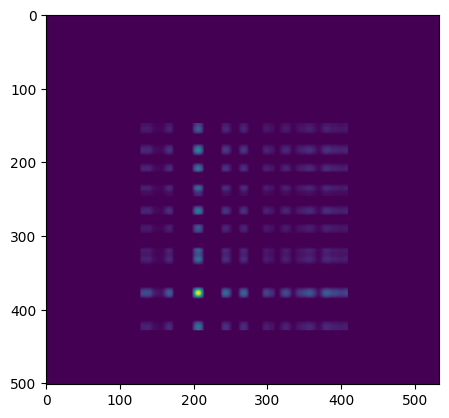

In [47]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## MMPose官方可视化工具`visualizer`

In [48]:
# 半径
pose_estimator.cfg.visualizer.radius = 10
# 线宽
pose_estimator.cfg.visualizer.line_width = 8
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

D:\Anaconda3\envs\openmmlab\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [49]:
# 元数据
# pose_estimator.dataset_meta

## 展示可视化效果

In [50]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show_kpt_idx=True,
            show=False,
            wait_time=0,
            out_file='outputs/B2.jpg'
)

In [51]:
img_output.shape

(1004, 534, 3)

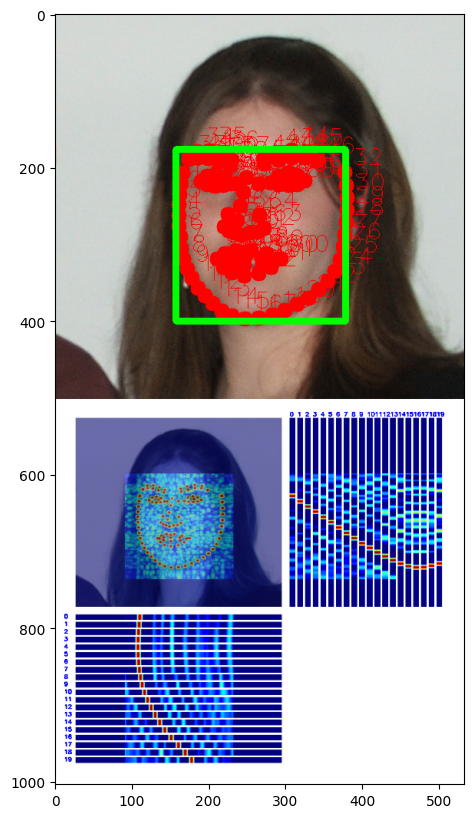

In [52]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()